# Workshop 4: Working with multi-dimensional data

In this workshop, we provide an introduction to working with multi-dimensional data in Python.

**The learning objectives are to:**
- provide a recap on multi-dimensional geospatial data using Python 
- provide basic understanding and examples of working with NetCDF file operations
- provide basic understanding and examples of working with CF metadata conventions
- provide a brief introduction to CF Python and cf-plot packages
- understand the basic data structures in Xarray and how to work with them

In this workshop (and related HydroJULES workshops) we use Python in Jupyter notebooks. We assume you know the basics of using Python for processing numerical data, and are familiar with Jupyter notebooks. If you would like to improve your confidence and ability with Python and Jupyter notebooks, there is a brief summary below and some learning resources at the end of this notebook. 

<details>
    <summary>NumPy, Pandas, and Matplotlib 101 </summary>

In this workshop we are assuming you know about [NumPy](https://numpy.org/) (Numerical Python) and [Pandas](https://pandas.pydata.org/). Numpy is a Python library that provides a multidimensional array object, various derived objects e.g. masked arrays, and an assortment of routines for fast operations on arrays. NumPy arrays are faster and more compact than Python lists. NumPy arrays contain data of the same type. An array is a central data structure of the NumPy library. An array is a grid of values and it contains information about the raw data, how to locate an element, and how to interpret an element. The rank of the array is the number of dimensions. The shape of the array is a tuple of integers giving the size of the array along each dimension.

Pandas is a widely used Python library that provides two types of data structure and is often used for data input and output operations. 
Series: a one-dimensional labeled array holding data of any type e.g. integer.
DataFrame: a two-dimensional data structure that holds data like a two-dimension array.

[GeoPandas](https://geopandas.org/en/stable/) extends the datatypes used by Pandas to allow spatial operations on geometric types. The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame`, that can store geometry columns and perform spatial operations. The geopandas.GeoSeries, a subclass of pandas.Series, handles the geometries. 

[Matplotlib](https://matplotlib.org/stable/) is a comprehensive library for creating static, animated, and interactive visualizations. Matplotlib graphs your data on `Figures` (e.g., windows, Jupyter widgets, etc.), each of which can contain one or more `Axes`, an area where points can be specified in terms of x-y coordinates.

</details>

## Multi-dimensional geospatial data 101
Multi-dimensional geospatial data refers to datasets that include multiple layers or dimensions of geographical information. This data goes beyond the simple two-dimensional latitude and longitude coordinates and often includes additional dimensions such as time, elevation (altitude), and other variables like temperature, humidity, population density, or any other measurable attribute.

This workshop was designed for an hour long session as part of the HydroJULES school. It does not cover all aspects of multi-dimensional data use by the Python scientific communities. Additonal resources can be found at the end of this notebook.



## Multi-dimensional data and Python packages
There are a wide range of Python packages that can be used with multi-dimensional files such as NetCDF files.
- In this workshop we focus on [netcdf4-python](https://unidata.github.io/netcdf4-python): is a Python interface to the netCDF C library.
- [cf-python](https://ncas-cms.github.io/cf-python/): a Python Earth Science data analysis library that is built on a complete implementation of the CF conventions.
- [xarray](https://docs.xarray.dev/en/stable/): makes working with labelled multi-dimensional arrays simple and efficient.



<details>
   <summary><b>NetCDF and netcdf4-python</b></summary>
netcdf4-python is a Python interface to the netCDF C library (Network Common Data Form). It provides a low level interface for working with netCDF datasets in Python. NetCDF refers to a set of software libraries and self-describing, machine-independant data formats that support the creation, access and sharing of array-oriented scientific data. NetCDF was developed in the late 1980s at the Unidata Program Centre, with the objective of building a file format that would permit sharing of data among atmospheric scientists. The stated objectives for the netCDF format were for it to be: self-describing, portable, scalable, appendable, shareable, and archivable. NetCDF4 in ~ 2011 provides the capability to apply attributes to a file as a whole, to a group within a file, or to any individual variable.

</details>

## Set up

In [1]:
from calendar import monthrange
import cf
import cfplot as cfp
from cftime import date2num
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np
import os as os
from pyproj import Proj
import time
import xarray as xr


%xmode minimal
%matplotlib inline
%config InlineBackend.figure_format='retina'

Exception reporting mode: Minimal


### JASMIN notebook service
See how many CPUs and how much RAM is available.

In [2]:
CPUs = os.cpu_count()
print("Total CPUs count:", CPUs)

total_memory, used_memory, free_memory = map(

int, os.popen('free -t -m').readlines()[-1].split()[1:])


print("RAM memory used (%):", round((used_memory/total_memory) * 100, 1))

print("RAM total (GB):", total_memory // 100)

Total CPUs count: 24
RAM memory used (%): 33.5
RAM total (GB): 3895


### Check what files are in the local data store

In [3]:
print("Current working directory is:")
print(os.getcwd()+"\n")

print("This directory contains this notebook and other notebooks in this data lab")
print(str(os.listdir('./'))+"\n")

print("Root directory contains:")
print(str(os.listdir('/'))+"\n")

Current working directory is:
/home/users/kitmac

This directory contains this notebook and other notebooks in this data lab
['.bash_logout', '.bash_profile', '.bashrc', '.emacs', '.ssh', '.local', '.ipython', '.jupyter', '.ipynb_checkpoints', 'netCDF4_tutorial.ipynb', 'clouds.nc', 'UKCEH_HJ_netCDF-examples_MeGoingThrough.ipynb', '.config', '.cache', 'UKCEH_HJ_netCDF_copied.ipynb', 'school', 'Learning_notebooks_on_JASMIN.ipynb', 'HJ_WS4_working_with_multidimensional_data.ipynb', 'JASMIN-data_explore.ipynb', 'Xarray-Tutorial.ipynb', 'HJ-SS_WS5-Outline.ipynb', 'test.zarr', 'HJ-SS_Introduction.md', '.bash_history', 'data', 'HJ-SS_Workshop-4.ipynb', 'HJ-SS_OlderVersions']

Root directory contains:
['media', 'lib64', 'etc', 'root', 'tmp', 'afs', 'sbin', 'dev', 'run', 'bin', 'var', 'mnt', 'home', 'srv', 'lib', 'proc', 'lost+found', 'sys', 'opt', 'usr', 'datacentre', 'work', 'gws', 'group_workspaces', '.dockerenv', 'pip-wheels', 'sparc', 'edc', 'neodc', 'badc', 'ngdc', 'bodc']



## netCDF
### Create gridded data 
We will generate gridded data to store in netCDF format. Then we will add metadata that follows the Climate and Forecasting conventions. This ensures the dataset can be used by a wide range of tools.

Our toy dataset will contain:
- Three spatial dimensions (`x`, `y`, and `press`) and one temporal dimension (`times`).
- The native coordinate system of the model is on a regular 3km x 3km (`x` and `y`) grid that represents the Earth.
- The vertical dimension (`press`) consists of several discrete pressure levels in units of hPa.
- The time dimension consists of 12 consecutive hours (`times`), beginning at 2200 UTC on the current day.
- A variable of interest (`temps`), which holds the data values at each unique dimensional index. 

These dimensional arrays are created by:

In [4]:
start = datetime.utcnow().replace(hour=22, minute=0, second=0, microsecond=0)
times = np.array([start + timedelta(hours=h) for h in range(13)])

x = np.arange(-150, 153, 3)
y = np.arange(-100, 100, 3)

press = np.array([1000, 925, 850, 700, 500, 300, 250])

temps = np.random.randn(times.size, press.size, y.size, x.size)


### Creating a new netCDF file
First we create a new netCDF file and set up the shared dimensions. We will be using the netcdf4-python package.
This file will reside in memory due to the `diskless=True` argument. To create a file on disk, remove it or add the `persist=True` argument.
Opening an existing file with `w` as the second argument, will result in existing data being overwritten. If you would like to edit the file, or add to it, open it using `a` as the second argument. 

In [5]:

nc = Dataset('example_data.nc', 'w', format='NETCDF4_CLASSIC', diskless=True)

# in case file is open, use nc.close()

### Start setup of this new netCDF file by adding global attribute metadata
These are recommended by the CF standard, but are not essential. 

In [6]:
nc.Conventions = 'CF-1.11'
nc.title = 'Example temperature data'
nc.institution = 'UKCEH'
nc.source = 'Made up'
nc.history = str(datetime.utcnow()) + ' Python'
nc.references = ''
nc.comment = ''
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.11
    title: Example temperature data
    institution: UKCEH
    source: Made up
    history: 2024-07-04 15:07:21.476476 Python
    references: 
    comment: 
    dimensions(sizes): 
    variables(dimensions): 
    groups: 

### Define dimensions of data, so we can add variables
We need to define the dimensions of the data, before we can add any variables to our file. 
Create dimensions called `x`, `y`, and `pressure`, and set the size of each dimension to the size of the corresponding data array. Set `forecast_time` size to None; this defines the dimension as 'unlimited', so data can be added.

In [7]:
nc.createDimension('forecast_time', None)
nc.createDimension('x', x.size)
nc.createDimension('y', y.size)
nc.createDimension('pressure', press.size)
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.11
    title: Example temperature data
    institution: UKCEH
    source: Made up
    history: 2024-07-04 15:07:21.476476 Python
    references: 
    comment: 
    dimensions(sizes): forecast_time(0), x(101), y(67), pressure(7)
    variables(dimensions): 
    groups: 

### Creating and adding a variable
Here we create a `netCDF4 variable` to hold a data field. This includes specifying its data type and dimensions. We can specify if we wish to compress the data.

In [8]:
temps_var = nc.createVariable(
    'Temperature',
    datatype=np.float32,
    dimensions=('forecast_time', 'pressure', 'y', 'x'), 
    zlib=True
)
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.11
    title: Example temperature data
    institution: UKCEH
    source: Made up
    history: 2024-07-04 15:07:21.476476 Python
    references: 
    comment: 
    dimensions(sizes): forecast_time(0), x(101), y(67), pressure(7)
    variables(dimensions): float32 Temperature(forecast_time, pressure, y, x)
    groups: 

Next we associate our temperature data with the new variable.

In [9]:
temps_var[:] = temps
temps_var

<class 'netCDF4._netCDF4.Variable'>
float32 Temperature(forecast_time, pressure, y, x)
unlimited dimensions: forecast_time
current shape = (13, 7, 67, 101)
filling on, default _FillValue of 9.969209968386869e+36 used

### Setting unit attributes
CF conventions require a `units` attribute to be set for all variables that represent a dimensional quantity. These enable a user to understand what each variable in a dataset represents.   

In [10]:
temps_var.units = 'Kelvin'
temps_var.standard_name = 'air_temperature'
temps_var.long_name = 'Forecast air temperature'
temps_var.missing_value = -9999
temps_var

nc.close()

## CF (Climate and Forecast) conventions
[CF Metadata Conventions](https://cfconventions.org/) provide a description of the physical meaning of data and their spatial and temporal properties. They aim:
- To enable you to locate data in space-time and as a function of other indpendent variables to facilitate processing and visualisatoni
- Identify data sufficiently to enable users of data from different sources to decide what is comparable, and to distinguish variables in archives.

 
**Principles**
- Data should be self-describing.
- Metadata readable by humans and computers.
- Avoid being too onerous for data-writers and data-readers. 
ng.


<details> 
    <summary>Further information on their design.</summary>

The CF metadata conventions are designed to promote the processing and sharing of files created with the NetCDF API. The conventions define metadata that provide a definitive description of what the data in each variable represents, and the spatial and temporal properties of the data. This enables users of data from different sources to decide which quantities are comparable, and facilitates building applications with powerful extraction, regridding, and display capabilities.

The CF data model identifies the fundamental elements (“constructs”) of the CF conventions and shows how they relate to each other, independently of the netCDF coding.
</details>

## Data for this workshop 
This workshop is going to explore meteorological driving data from November 2019. The winter of 2019/2020 included periods of very high precipitation, which led to widespread flooding in central and northern England.

Here we access the data from the JASMIN Hydro-JULES group workspace. These data are also available from the [Environmental Information Data Centre](https://eidc.ac.uk/) and the [CEDA Archive](https://archive.ceda.ac.uk/). 

In this workshop we will be using data from the [Climate hydrology and ecology research support system -CHESS](https://catalogue.ceh.ac.uk/documents/7de9790e-66a2-44b5-988e-283d764ef52f).

### Floods and Droughts Research Infrastructure
In June 2022, the UK Research and Innovation department [announced](https://www.ukri.org/what-we-do/creating-world-class-research-and-innovation-infrastructure/funded-infrastructure-projects/) their intention to invest £38M towards the establishment of a nationwide, digitally enabled Floods and Droughts Research Infrastructure. The core hydrological infrastructure is based around three catchments (100-170 km^2). Further details are available in the UKCEH [FDRI scoping project: community report](https://www.ceh.ac.uk/our-science/projects/floods-and-droughts-research-infrastructure-fdri-scoping-report).

**National River Flow Archive stations**
- [Tweed at Kingledores](https://nrfa.ceh.ac.uk/data/station/info/21014)
- [Severn at Dolwen](https://nrfa.ceh.ac.uk/data/station/info/54080)
- [Chess at Rickmansworth](https://nrfa.ceh.ac.uk/data/station/info/39088)



### 1km daily precipitation data 

In [11]:
path = '/gws/nopw/j04/hydro_jules/data/uk/driving_data/chess/chess-met/daily/'
file = 'chess-met_precip_gb_1km_daily_20191101-20191130.nc'

### Locations of the three FDRI catchment outlets 

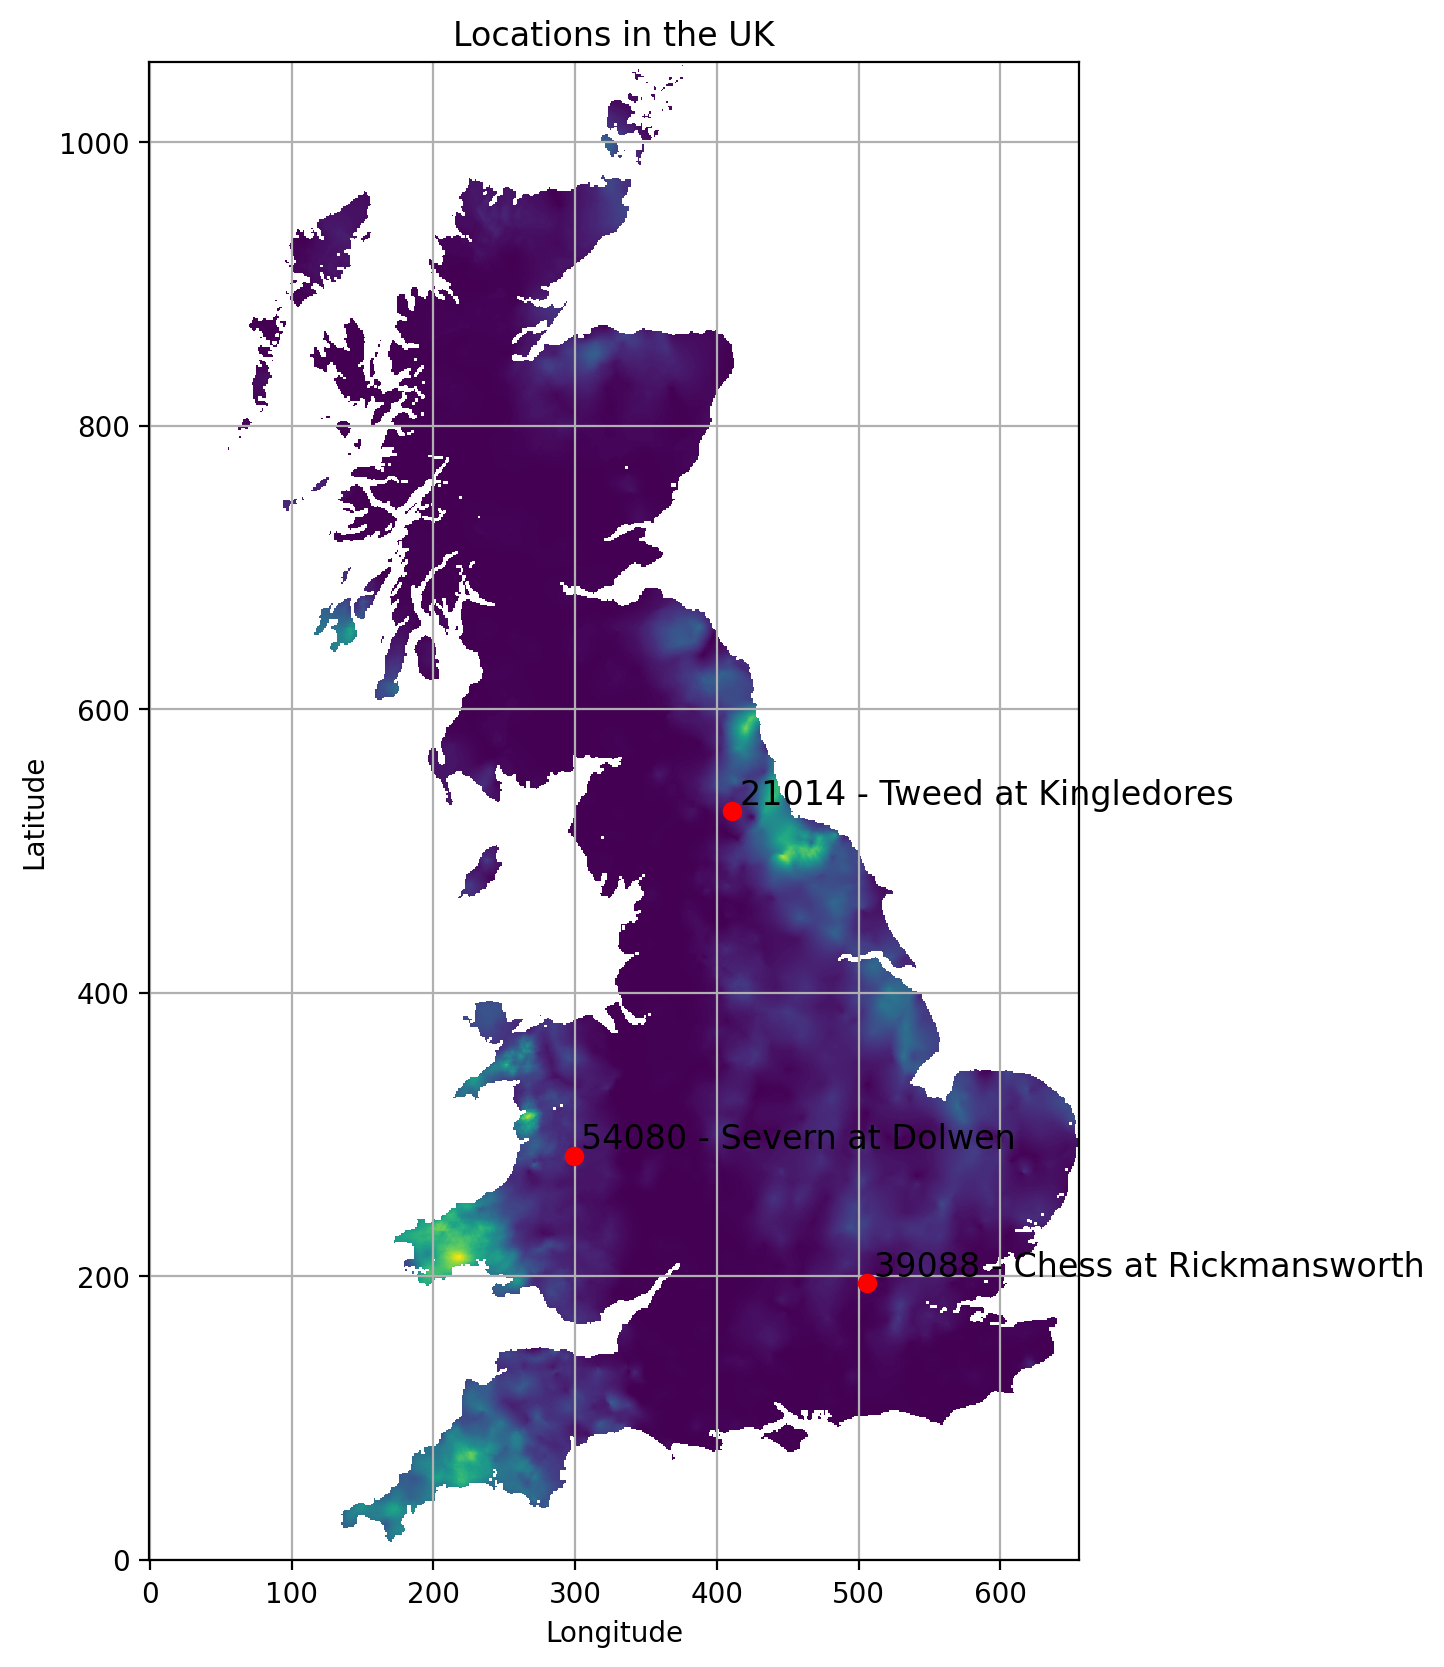

In [12]:
# Open the netCDF file
dataset = Dataset(path+file)

precipDataS = dataset.variables['precip'][:,528,411] # kg/m2/s
precipDataD = precipDataS*86400 # mm/day

# Day 7
precipMapST0 = dataset.variables['precip'][7,:,:]
precipMapDT0 =  precipMapST0*86400 

# Specify the locations (lat, lon)
locations = [
    (528, 411),  # 21014 - Tweed at Kingledores
    (285, 299),  # 54080 - Severn at Dolwen
    (195, 506)   # 39088 - Chess at Rickmansworth
]

# Extract the coordinates and labels
latitudes, longitudes = zip(*locations)
labels = ['21014 - Tweed at Kingledores', '54080 - Severn at Dolwen', '39088 - Chess at Rickmansworth']

# Plot the map of the UK and the locations
plt.figure(figsize=(6, 10))
plt.imshow(precipMapDT0, origin='lower')
plt.scatter(longitudes, latitudes, color='red', zorder=5)
for i, label in enumerate(labels):
    plt.text(longitudes[i] + 5, latitudes[i] + 5, label, fontsize=12, color='black', zorder=10)

plt.title('Locations in the UK')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.legend()
plt.grid(True)
plt.show()


### Plotting the precipitation data

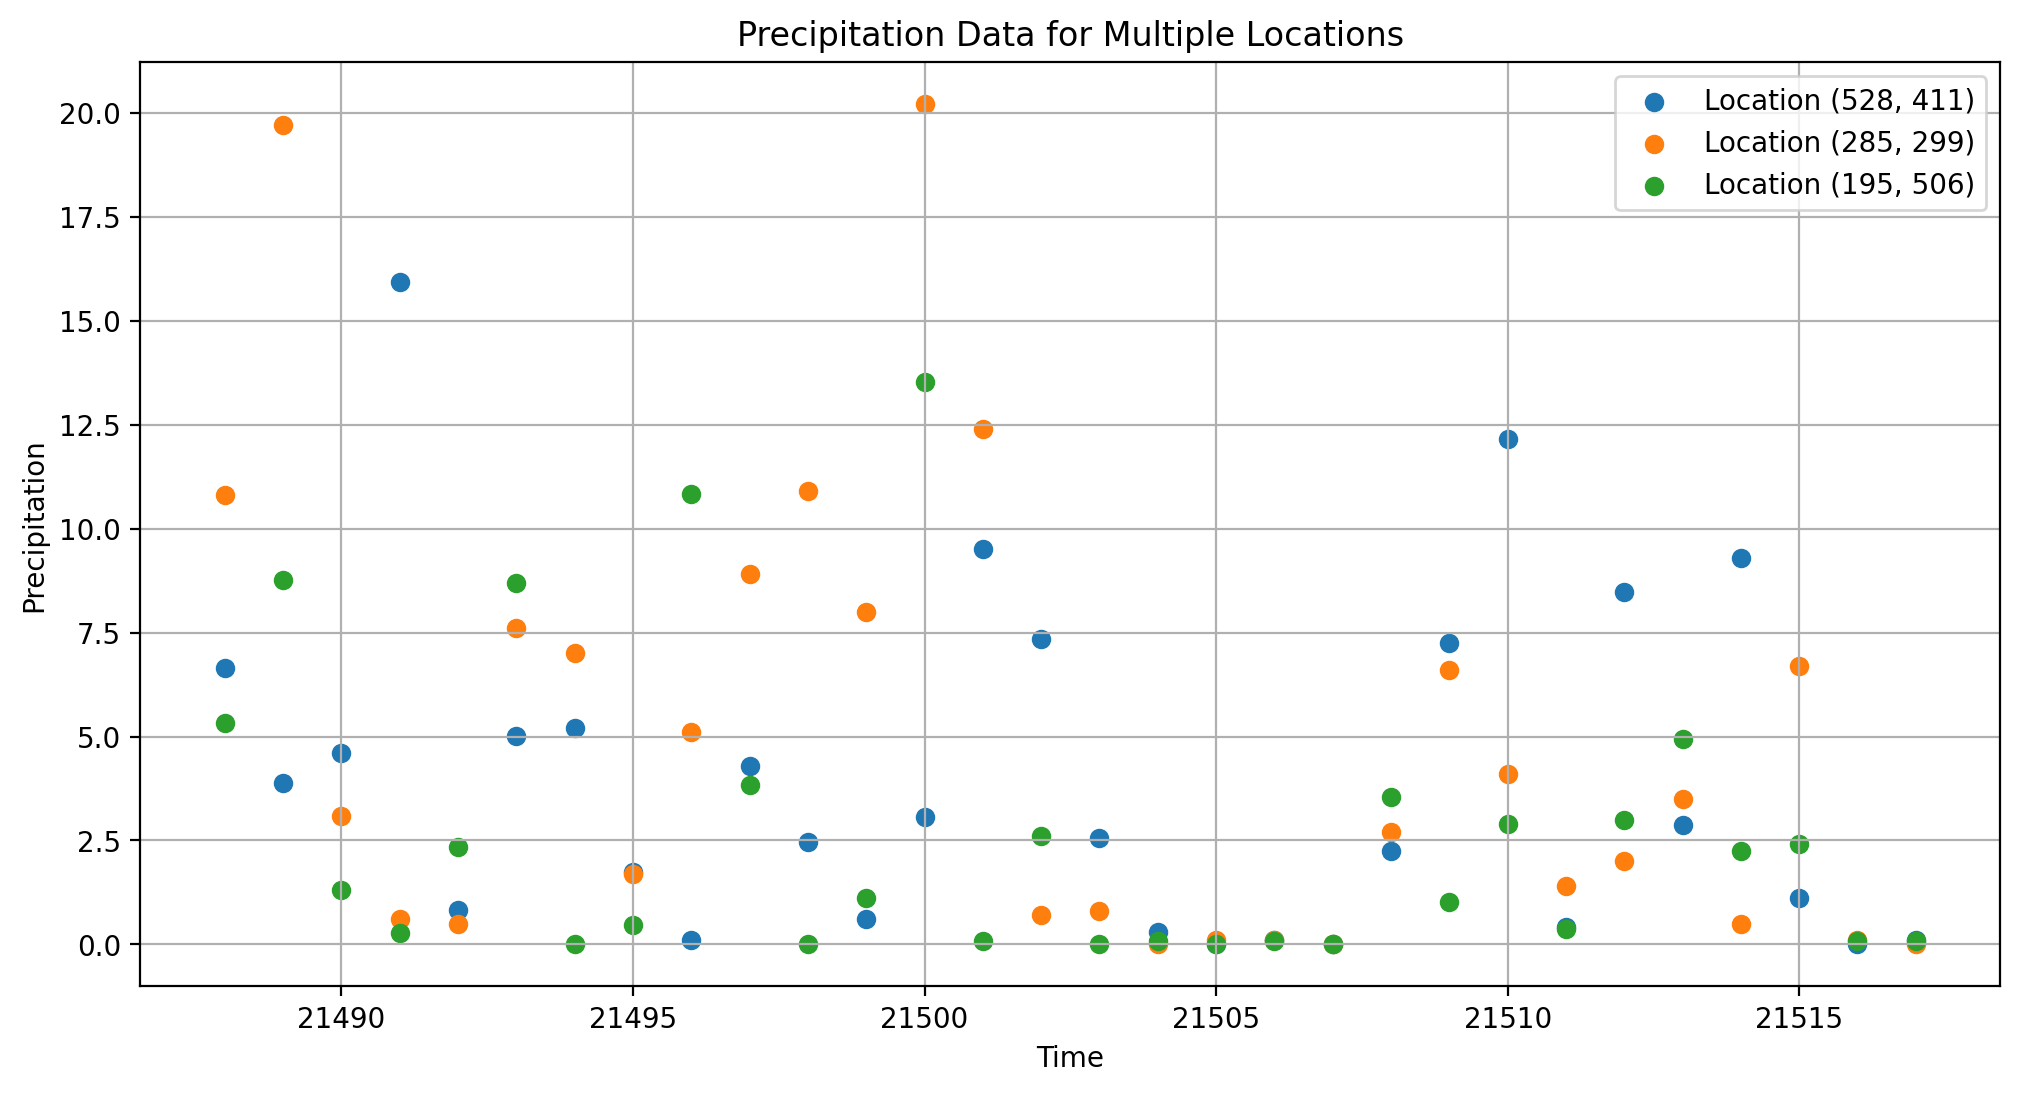

In [14]:
# Extract the precipitation variable
precip = dataset.variables['precip']  # Replace 'precipitation' with the actual variable name

# old
# Initialize lists to store time and precipitation data for each location
time = dataset.variables['time'][:]  # Adjust as necessary to get the time variable
precip_data = []

# Loop over each location to extract data
for loc in locations:
    lat, lon = loc
    # Convert from kg/m²/s to mm/day by multiplying by 86400
    precip_data.append(precip[:, lat, lon] * 86400)

# Plotting the data
plt.figure(figsize=(12, 6))

# Todo fix label
# latitudes, longitudes = zip(*locations)
# labels = ['21014 - Tweed at Kingledores', '54080 - Severn at Dolwen', '39088 - Chess at Rickmansworth']
# for i, label in enumerate(labels):
#     plt.text(longitudes[i] + 5, latitudes[i] + 5, label, fontsize=12, color='black', zorder=10)

for i, loc in enumerate(locations):
    plt.scatter(time, precip_data[i], label=f'Location {loc}',)

plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('Precipitation Data for Multiple Locations')
plt.legend()
plt.grid(True)
plt.show()

# Close the dataset
dataset.close()


### Explore the variables in a netCDF file

In [ ]:
# Write out the variables in a netCDF file
my_dataset = Dataset(path+file)

print("Loop through variables and print variable name:")
for v in my_dataset.variables:
    print(v)
print("\n")

print("Select one variable by its name and print one metadata attibute ('units'), \
 and the dimensions and shape of the variable:")

print("Units : "+my_dataset.variables['precip'].units)
print("Dimensions : "+str(my_dataset.variables['precip'].dimensions))
print("Shape : "+str(my_dataset.variables['precip'].shape))
print("\n")

print("Print full metadata for all variables:")
print("\n")
print(my_dataset.variables)

my_dataset.close()  

### A closer look at the precipitation variable and data

In [ ]:
my_dataset = Dataset(path+file)

print("First get the precipitation 'precip' variable, and show its dimensions")
precip_var = my_dataset.variables['precip']
print("Dimensions : "+str(precip_var.dimensions))
print("\n")

print("Then get the precipitation from this variable and check its type and shape:")
precip=precip_var[:]
print("Type : "+str(type(precip)))
print("Shape : "+str(precip.shape))
print("\n")

print("It's a 3D masked array (array of data values, plus another array of mask values) \
with a grid of X-Y values for each day of June 2019")
print("\n")

print("First, look at the mask")
print("It has the same shape as the values:")
precip_mask = precip.mask
print("Type : "+str(type(precip_mask)))
print("Shape : "+str(precip_mask.shape))
print("Unique values : "+str(np.unique(precip_mask)))
print("\n")

print("Make a quick plot of the mask for the first time step:")
plt.imshow(precip_mask[0,:,:], origin='lower')

my_dataset.close() 

### Explore the spatial variables: latitude/longitude, and X/Y

In [ ]:
# Find the lat long of the grid cell at x = 400, y=500
# Amulya code - maybe reduce in half
my_dataset = Dataset(path+file)

print("First get the x and y variables and show its dimensions and shape")
x_var = my_dataset.variables['x']
print("Dimensions : "+str(x_var.dimensions))
print("Shape : "+str(x_var[:].shape))
y_var = my_dataset.variables['y']
print("Dimensions : "+str(y_var.dimensions))
print("Shape : "+str(y_var[:].shape))
print("\n")

print("They are 1D arrays of the British National Grid easting and northing coordinate values")
print("of the centre points of the data cells at the equivalent grid cells in the data array")
print("\n")

print("For example, the easting and northing of the value at index 500,400 is:")
print("Easting : "+str(x_var[500]))
print("Northing : "+str(y_var[400]))
print("\n")

print("There is also a variable containing the minimum and maximum easting and northing for each grid cell")
x_bnd_var = my_dataset.variables['x_bnds']
print("Dimensions : "+str(x_bnd_var.dimensions))
print("Shape : "+str(x_bnd_var[:].shape))
y_bnd_var = my_dataset.variables['y_bnds']
print("Dimensions : "+str(y_bnd_var.dimensions))
print("Shape : "+str(y_bnd_var[:].shape))
print("\n")

print("The boundaries of the cell at index 500,400 is:")
print("Easting : "+str(x_bnd_var[500,:]))
print("Northing : "+str(y_bnd_var[400,:]))
print("\n")

print("Next get the lat variable, and show its dimensions")
lat_var = my_dataset.variables['lat']
print("Dimensions : "+str(lat_var.dimensions))
print("\n")

print("Then get the latitude from this variable and check its type and shape:")
lat=lat_var[:]
print("Type : "+str(type(lat)))
print("Shape : "+str(lat.shape))
print("\n")

print("It's a 2D masked array (array of values. plus another array of mask values)")
print("The dimensions are X and Y : there is a different latitude values for each combination of X and Y")
print("\n")

print("But look at the shape of the mask - it's different from the values:")
lat_mask = lat.mask
print("lat mask type : "+str(type(lat_mask)))
print("lat mask shape : "+str(lat_mask.shape))
print("lat mask : "+str(lat_mask))
print("\n")

lat_data=lat.data
print("lat data type : "+str(type(lat_data)))
print("lat data shape : "+str(lat_data.shape))
print("\n")
print("The mask is just a single value 'False'. \
netCDF4 variables will be masked arrays, but we cannot expect the mask to be the same size as the data.")
print("Though often, particularly in Hydro-JULES datasets, the data variables will have a mask to enable \
the points with data (land points) to be readily identified")
print("\n")

print("The data is a numpy array, and we can simply select the value at the indices of interest.")
grid_lat = lat_data[500,400]
print("\n")

# Get the longitude directly in one line
grid_lon = my_dataset.variables['lon'][:].data[500,400]

print("Lat and Long at y=500, x=400 is:")
print([grid_lat,grid_lon])

my_dataset.close()  

### Find the nearest cell for a given easting and northing, or latitude and longitude

In [ ]:
easting = 529010
northing = 180220

my_dataset = Dataset(path+file)

# Get the easting and northing variables from the dataset
x = my_dataset.variables['x'][:]
y = my_dataset.variables['y'][:]

# Get the index of the closest value to the easting and northing (the index of the cell we want)
idx_e = (np.abs(x - easting)).argmin()
idx_n = (np.abs(y - northing)).argmin()
print('Original easting and northing : {}, {} \n'.format( *[ easting, northing ] ))
print('Nearest cell at easting {} , northing {} within index [{},{}] \n'.format( *[ x[idx_e] , y[idx_n] , idx_e, idx_n ]))

my_dataset.close()

The lat and long variables are 2 dimensional arrays of the value at each cell (defined by easting and northing) This means identifying the nearest cell for a given lat and long is not so simple (it's not just the cell with the nearest latitude and the cell with the nearest longitude). This code quickly identifies the X and Y indices for the nearest cell for a given lat and long.

In [ ]:
# Latitude and longitude of interest:
my_lat = 54.39
my_lon = -1.99

# Open the dataset
my_dataset = Dataset(path+file)
# retrieve the lat and long arrays
lat = my_dataset.variables['lat'][:]
lon = my_dataset.variables['lon'][:]
# Create new arrays of the distance for each cell from the given latitude and the given longitude
lat_dist = abs(lat-my_lat)
lon_dist = abs(lon-my_lon)
# Create an array of the absolute distance (in degrees)
dist_diff = np.sqrt( np.square(lat_dist) + np.square(lon_dist) )
# Find the cell where this distance is a minimum
idx = np.where( dist_diff == np.min(dist_diff) )

my_x = idx[0][0]
my_y = idx[1][0]

# Get the precipitation data for this location (convert from kg/m²/s to mm/day) 
precip = my_dataset.variables['precip'][ :, my_y, my_x ] * 86400

my_dataset.close()

print("Nearest grid cell is : "+str(idx))
print("\n")

# Show the grids around this point
grid_size=2
minx = my_x-grid_size
maxx = my_x+grid_size+1
miny = my_y-grid_size
maxy = my_y+grid_size+1

with np.printoptions(precision=7):
    print("Latitude values nearby")
    print(lat[minx:maxx,miny:maxy])
    print("\n")
    print("Longitude values nearby")
    print(lon[minx:maxx,miny:maxy])
    print("\n")
    print("Distances from given lat/long nearby ")
    print(np.round(dist_diff[minx:maxx,miny:maxy],5))
    print("\n")
    print("Minimum distance:")
    print (np.min(dist_diff))
    print("\n")
print("Data for point [{},{}]".format( *[ my_x, my_y ]))
# plt.plot(precip, 'bo')

### Explore the time variable

In [ ]:
# Use the time variable to identify the correct indices for dates of interest
start_date = date ( year=2019, month=11, day=1)        # 01/11/2019
end_date = date ( year=2015, month=11, day=30)         # 30/11/2019

var = 'precip'                                            # Precipitation

# Open the dataset
my_dataset = Dataset(path+file)

# Get the time variable from the dataset
print('Time variable units:')
print(my_dataset.variables['time'].units+':\n')
my_dates = my_dataset.variables['time'][:]

# Get the index of the start and end date 
# (the array "dates" is a list of the dates expressed as the number of days since 1961)
s_days = ( start_date - date( year=1961, month=1, day=1 ) ).days
idx_start = (np.abs(my_dates - s_days)).argmin()
e_days = ( end_date - date( year=1961, month=1, day=1 ) ).days
idx_end = (np.abs(my_dates - e_days)).argmin()

# Get the data (air temp) variable
precip = my_dataset.variables[var]

# Write out the metadata
print('Precipitation variable information:')
print(precip)
print("\n")

# Get the data between the start and end date index, at the easting and northing indices calculated earlier
ts_data = precip[ idx_start:idx_end, my_y, my_x ]

# Close the dataset
my_dataset.close()

# Todo

print("Data for index {} to {} :".format( *[ idx_start, idx_end ] ))
print(ts_data)

## Read a netCDF dataset over the web
netCDF files are commonly made available over the web using a THREDDS server. Datasets made accessible in this way can be readily queried using exactly the same code as described above, but reading from a THREDDS API end point instead of a file.

This example reads air temperature data from the CHESS dataset hosted bu UKCEH's EIDC. In this case the entire dataset is available, but the web-based access is considerably slower than file access.

In [16]:
# Instead of a file, we are now going to access data over the web
# The interface to the dataset, made accessible through a THREDDS server, is at:
url = "https://eip.ceh.ac.uk/thredds/dodsC/public-chess/driving_data/aggregation/precip_aggregation"

# We access the netCDF dataset object in the same way as before
my_dataset = Dataset(url)

for v in my_dataset.variables:
    print(v)
print("\n")

print(my_dataset)
print("\n")
print(my_dataset.dimensions)
print("\n")
print(my_dataset.variables)
print("\n")

print(my_dataset.variables["precip"])
print("\n")

# Get the time variable from the dataset
print("Time variable units:")
print(my_dataset.variables["time"].units+":\n")

# Whole time series from this aggregation is >50 years, so select an arbitrary subset for an arbitrary cell
# my_dates = my_dataset.variables["time"][500:530]
ts_data = my_dataset.variables["precip"][500:530,400,500]

# Todo

plt.plot(ts_data, 'bo')


my_dataset.close()

crs
x
y
time
lat
lon
precip


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: CEH Gridded Estimates of Areal Rainfall aggregation
    institution: CEH Wallingford - NERC
    source: CEH - GEAR: dataset created using Natural Neighbour method interpolation on UK raingauge data
    reference: Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, J., Cole, S.J., Morris, D.G., Dixon, H. (2014). Consolidation of a CEH reference rainfall dataset for hydrological purposes for the UK. CEH-Wallingford, Oxfordshire, UK.
    grid_mapping: crs
    keywords: rainfall, raingauge, gridded, Natural Neighbour interpolation
    creator_url: 
    time_coverage_start: 1961-01-01
    time_coverage_end: 2015-12-31
    licence: Licensing conditions apply (datalicensing@ceh.ac.uk)
    publisher_name: Centre for Ecology and Hydrology
    publisher_url: http://www.ceh.ac.uk
    publisher_email: enquiries@ceh.ac.uk
    Conventions: CF-1.6
    comment: In line 

/tmp/ipykernel_8415/3882381347.py:28: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ts_data = my_dataset.variables["precip"][500:530,400,500]


## cf Python and cf-plot

The Python [cf package](https://ncas-cms.github.io/cf-python/index.html) is an Earth Science data analysis library that is built on a complete implementation of the CF data model.
It can be used to read and write NetCDF files. 

[cf-plot](https://ajheaps.github.io/cf-plot/) is a set of Python routines for making the common contour, vector and line plots that climate researchers use.

## Xarray

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like multidimensional arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.


What labels enable
Datasets often have labels which encode information about how array values map to locations in space, time, etc.



### Core data structures
Xarray has two core data structures (both are fundamentally N-dimensional):
`DataArray` is a labeled, N-dimensional array.
`Datset` is a multi-dimensional, in-memory array database. It is a dict-like container of `DataArray` objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the pandas.DataFrame. 
The power of the dataset over a plain dictionary is that, in addition to pulling out arrays by name, it is possible to select or combine data along a dimension across all arrays simultaneously.
The data model is borrowed from netCDF file format, which also provides xarray with a natural and portable serialization format. 


In [ ]:

 # Get a month's worth of CHESS precipitation data from a local file
# With JASMIN gws path
path = '/gws/nopw/j04/hydro_jules/data/uk/driving_data/chess/chess-met/daily/'
file = 'chess-met_precip_gb_1km_daily_20191101-20191130.nc'

# Open the netCDF file
ds = xr.open_dataset(path+file)



In [ ]:
ds

### Exploring a Dataset and its DataArrays

In [ ]:
Datasets are dictionary-like containers of “DataArray”s.

In [ ]:
# use dictionary syntax to extract dataarray
ds["precip"]

In [ ]:
# use dot notation to extract dataarray

In [ ]:
ds.precip

A DataArray contains data and metadata

In [ ]:
da = ds.precip

da.name

Named dimensions
.dims correspond to the axes of your data.

In [ ]:
da.dims

Coordinate variables
.coords is a data container for coordinate variables.


Advantages of Xarray
Xarray supports using dimension names instead of axis numbers

In [ ]:
ds.precip.mean(dim="time").plot()

In [ ]:
Xarray supports label based positioning

In [ ]:
ds.sel(time="2019-11-7")

In [ ]:
# demonstrate slicing
ds.sel(time=slice("2019-11-01", "2019-11-07"))

## Additional resources

Py

Python and Jupyter notebooks

JupyterLab Documentation — JupyterLab 4.2.2 documentation
https://jupyterlab.readthedocs.io/en/stable/

ceda-notebooks/notebooks/training/intro at master · cedadev/ceda-notebooks
https://github.com/cedadev/ceda-notebooks/tree/master/notebooks/training/intro

JASMIN

ceda-notebooks/notebooks/training/intro/notebook-tour.ipynb at master · cedadev/ceda-notebooks
https://github.com/cedadev/ceda-notebooks/blob/master/notebooks/training/intro/notebook-tour.ipynb

cedadev/jasmin-workshop: Materials and code for JASMIN workshops
https://github.com/cedadev/jasmin-workshop

Python
Scientific Python Lectures — Scientific Python Lectures
https://lectures.scientific-python.org/

### Packages

[cf](https://ncas-cms.github.io/cf-python/index.html)


NumPy
NumPy: the absolute basics for beginners — NumPy v2.0 Manual
https://numpy.org/doc/stable/user/absolute_beginners.html


NetCDF

CF

cf


Xarray
Xarray documentation
https://docs.xarray.dev/en/stable/index.html

Terminology
https://docs.xarray.dev/en/stable/user-guide/terminology.html